In [ ]:


#The main file for case 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Path to main file
file_Moa = "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/FALL2_2.TXT"


# Read as space-separated values
df = pd.read_csv(file_Moa, delim_whitespace=True, header=None)




#retrieve variables
R = df.iloc[:, 8].to_numpy()  # Nettradiationn in column 23
G= df.iloc[:, 9] # GROUND HEAT FLUX AT EACH HEGHT in column 18-22 (22 INCLUDED)
p=df.iloc[:, 7].to_numpy()  # air pressure
theta= df.iloc[:, 5].to_numpy()  # Potential temperature at height
r= df.iloc[:,6].to_numpy() #relative humidity at height 2
u= df.iloc[:,4].to_numpy() #windspeed at height 10.1m 

#Constants
rho =  1.225 # kg/m³ - density of air at sea level (is it always the same?)
c_p= 1005 # J/(kg·K) specific heat of air at sea level
gamma= 0.066 # kPa °C - psycometric constant γ=cp⋅P/ (ε⋅λ)  (lambda is latent heat of vaporization, epsilon molecular weight of water vapor to dry air)
r_l = 100 #s m^-1 stomatal resistance of single leaf (well watered condition)

karman= 0.41
z_0m=0.0329
z_0h=0.00177


#Changes in different height cases!
h_max= 1.5 #m (approx for barley)
LAI_max= 4 #barley
n= 1 # barley 1-2
h = 10*z_0m
d = 0.65*h  

LAI= LAI_max * (h / h_max)**n

LAI_active= 0.5 * LAI
r_s = r_l/LAI_active # 



In [19]:
# help functions

def pottemp_to_temp(theta):
    T=theta * 1**0.286
    return T


# we calculate difference e_s-e_a
def vapour_pressure_deficit(T): 
    e_s= 0.6108 * np.exp(17.27 * T / (237.3 +T)) #Tetens equation
    T_min=np.min(T)
    e_a= r / 100 * e_s       #e_s(T_min)
    return e_s-e_a

# slope of the saturation curve
def gradient_e_s (e_s,T): 
    delta=e_s * 17.63 * T / (237.3 + T)**2
    return delta

def resistance_aero(z_m, z_h, d, z_0m, z_0h, u):
    print("z_m:", type(z_m))
    print("z_h:", type(z_h))
    print("d:", type(d))
    print("z_0m:", type(z_0m))
    print("z_0h:", type(z_0h))
    print("u:", type(u))
    with np.errstate(divide="ignore", invalid="ignore"):
        r_a = (np.log((z_m - d) / z_0m) * np.log((z_h - d) / z_0h)) / (karman**2 * u)
    
    #Replace invalid/very large values with NaN
    r_a = np.where(np.isfinite(r_a), r_a, np.nan)
    r_a = np.where((r_a > 1e6) | (r_a < 0), np.nan, r_a)  # optional thresholding
    
    return r_a



    

In [20]:
z_m= 10.1 #m heigth of wind meausurement 
z_h=1.95 #m height of humidity measurement
T = pottemp_to_temp(theta) # Temperature 
e_s= 6.112 * np.exp(17.63 * T/ (243.12 +T)) #Tetens equation
e_sa= vapour_pressure_deficit(T) # use temperature at the lowest level to find water vapor deficit
delta= gradient_e_s(e_s, T)
r_a = resistance_aero(z_m,z_h, d, z_0m,z_0h, u)





z_m: <class 'float'>
z_h: <class 'float'>
d: <class 'float'>
z_0m: <class 'float'>
z_0h: <class 'float'>
u: <class 'numpy.ndarray'>


In [21]:
# Penman eq
#Debug print shapes and types
for name, var in {
    "delta": delta,
    "R": R,
    "G": G,
    "rho": rho,
    "c_p": c_p,
    "e_sa": e_sa,
    "r_a": r_a,
    "gamma": gamma,
    "r_s": r_s,
}.items():
    try:
        print(f"{name}: shape={np.shape(var)}, type={type(var)}, dtype={getattr(var, 'dtype', 'NA')}")
    except Exception as e:
        print(f"{name}: error checking -> {e}")

ET= delta * (R-G) + rho * c_p * e_sa/r_a  / ( delta + gamma * (1 + r_s/ r_a) )



delta: shape=(144,), type=<class 'numpy.ndarray'>, dtype=float64
R: shape=(144,), type=<class 'numpy.ndarray'>, dtype=float64
G: shape=(144,), type=<class 'pandas.core.series.Series'>, dtype=float64
rho: shape=(), type=<class 'float'>, dtype=NA
c_p: shape=(), type=<class 'int'>, dtype=NA
e_sa: shape=(144,), type=<class 'numpy.ndarray'>, dtype=float64
r_a: shape=(144,), type=<class 'numpy.ndarray'>, dtype=float64
gamma: shape=(), type=<class 'float'>, dtype=NA
r_s: shape=(), type=<class 'float'>, dtype=NA


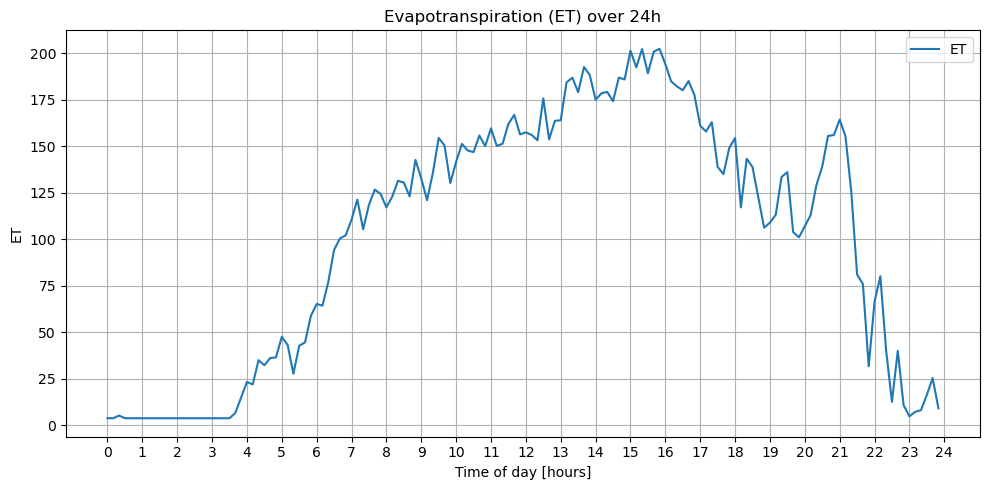

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Continuous time axis in hours (0–24 in 10 min steps)
time_hours = np.arange(0, 24, 10/60)   # 144 points

plt.figure(figsize=(10,5))
plt.plot(time_hours, ET, label="ET")
plt.xlabel("Time of day [hours]")
plt.ylabel("ET")
plt.title("Evapotranspiration (ET) over 24h")
plt.grid(True)

# Show ticks every hour
plt.xticks(range(0, 25, 1))

plt.legend()
plt.tight_layout()
plt.show()